In [1]:
install.packages("tidyverse")
library(tidyverse)
# Data Handling

if (!requireNamespace("BiocManager"))
    install.packages("BiocManager")
BiocManager::install()
library(BiocManager)
# General bioinformatics packages

library(BSgenome)
library(BSgenome.Hsapiens.UCSC.hg19)
# Human genome build GChr37

BiocManager::install("GWASTools", version = 3.8)
library("GWASTools")
# Manhattan Plot Builder


The downloaded binary packages are in
	/var/folders/g9/9x6m35fn5ydf88vdlm9n1vg80000gn/T//RtmpYN02YP/downloaded_packages


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [38]:
genome <- BSgenome.Hsapiens.UCSC.hg19

In [77]:
chr1 <- genome$chr1
length(chr1)

[1] 249250621

In [62]:
new_data <- read_tsv("/Volumes/CCG8/processed_data/brca_tcga/data_mutations_extended.txt")

Warning message:
“Missing column names filled in: 'X54' [54]”Parsed with column specification:
cols(
  .default = col_character(),
  Entrez_Gene_Id = col_integer(),
  Start_Position = col_integer(),
  End_Position = col_integer(),
  Score = col_integer(),
  t_ref_count = col_integer(),
  t_alt_count = col_integer(),
  Protein_position = col_integer(),
  Hotspot = col_integer(),
  stop_WU = col_integer(),
  X54 = col_double(),
  tumor_vaf = col_double(),
  normal_ref_reads = col_integer(),
  start_WU = col_integer(),
  strand_WU = col_integer(),
  tumors_var_reads = col_integer(),
  normal_vaf = col_double(),
  tumor_ref_reads = col_integer(),
  normal_var_reads = col_integer()
)
See spec(...) for full column specifications.
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“3282 parsing failures.
row # A tibble: 5 x 5 col     row col     expected  actual file                                         

In [76]:
abridge <- function(maf_file, nonsilent = TRUE) {
# Takes a maf file and selects the characteristics required to perform TMB analysis
# and removes duplicate entries (which exist for a variety of reasons, consult
# the TCGA website)
# Requires tidyverse
    
    data_abridged <- maf_file %>% 
       select('Hugo_Symbol', one_of(c('Start_Position','Start_position')), one_of(c('End_Position','End_position')), Strand, Variant_Classification, Variant_Type, Reference_Allele, Tumor_Seq_Allele1, Tumor_Seq_Allele2, Tumor_Sample_Barcode,  Score) %>% 
        distinct()

    if (nonsilent == TRUE) {
        data_abridged <- data_abridged %>% 
            filter(Variant_Classification %in% c('Frame_Shift_Del', 'Frame_Shift_Ins', 'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site', 'Translation_Start_Site'))
              }
    return(data_abridged)
}

In [70]:
TMB_Calc <- function(maf_file, nonsilent = TRUE) {
# Takes a maf file and outputs a table with tumor sample barcode and TMB value
# Requires tidyverse to be installed
# Depends on previous function 'abridge()'
    
    tmb_table <-  maf_file %>%  
                abridge(nonsilent = nonsilent) %>% 
                group_by(Tumor_Sample_Barcode) %>% 
                summarise(TMB = n()/30)
    
    return(tmb_table)
}

In [106]:
Local_TMB_Calc <- function(maf_file, Chromosome, Start_Position, Window_Size, nonsilent = FALSE) {
# takes a maf file and outputs a table with tumor sample barcode and local TMB 
# value for the window specified via chromosome, start position and window size
# requires tidyverse to be installed
# requires function 'abridge()'
    
    local_tmb_table  <- maf_file %>% 
        abridge(nonsilent = nonsilent) %>%
        filter(Chromosome == Chromosome) %>% 
        filter(Start_Position %in% (Start_Position + 0:(Window_Size-1))) %>% 
        group_by(Tumor_Sample_Barcode) %>% 
        summarise(Local_TMB = n())
    
    return(local_tmb_table)
}

Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”Warning message in Start_Position + 0:(Window_Size - 1):
“longer object length is not a multiple of shorter object length”Warning message:
“Unknown columns: `Start_position`”Warning message:
“Unknown columns: `End_position`”

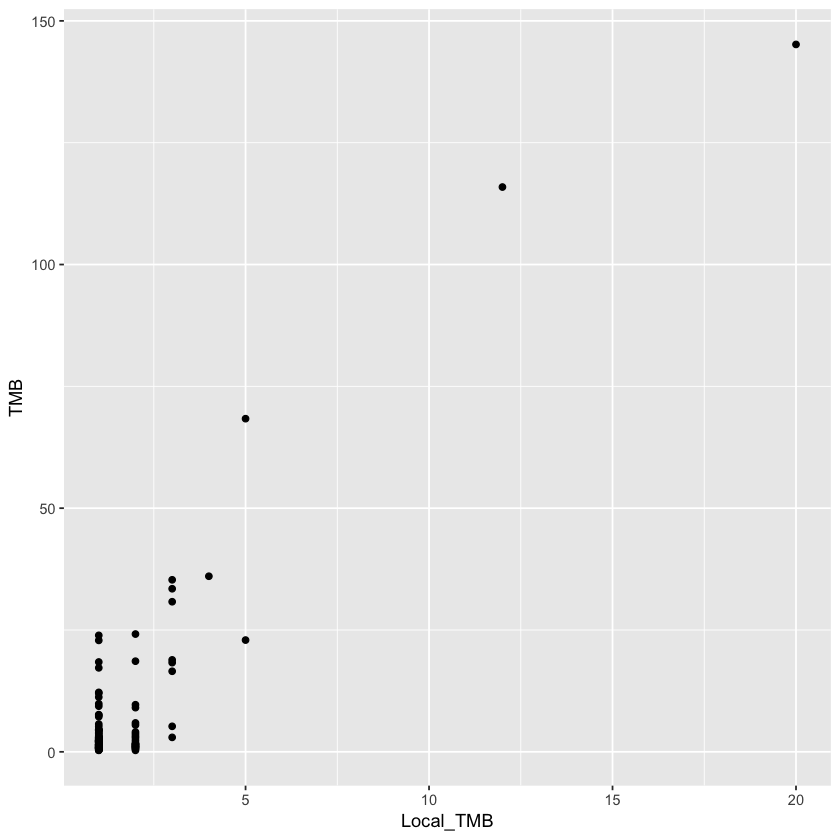

In [122]:
inner_join((new_data %>% 
                Local_TMB_Calc(Chromosome = 1, Start_Position = 5000000, Window_Size = 1000)),
            (new_data %>% 
                TMB_Calc()),
           by = "Tumor_Sample_Barcode")  %>% 
   ggplot(aes(x = Local_TMB, y = TMB)) + geom_point() #+ scale_x_log10() + scale_y_log10()

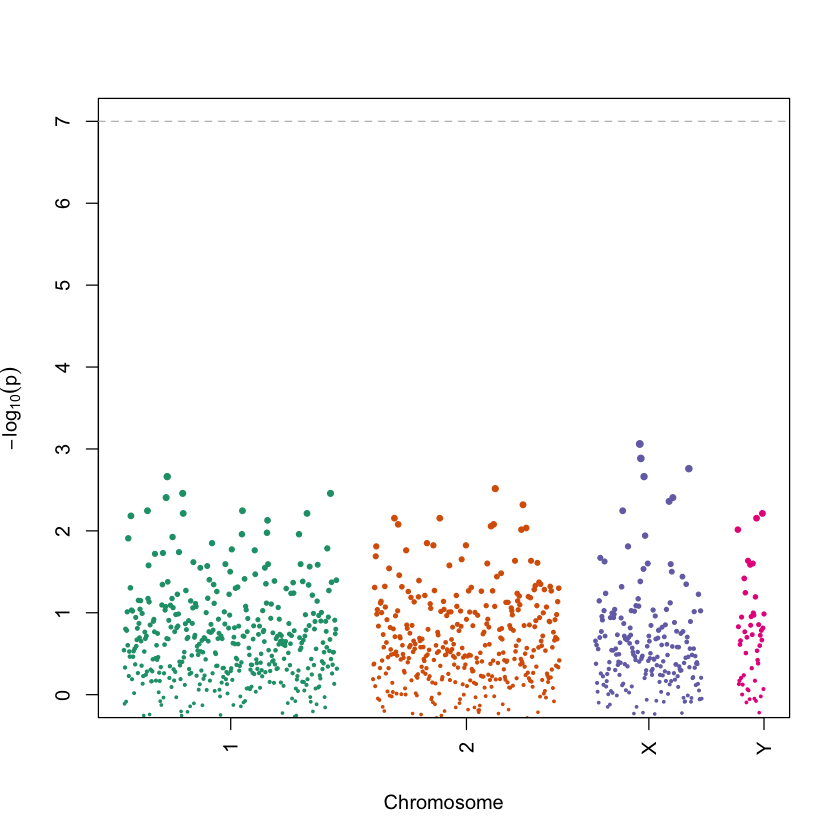

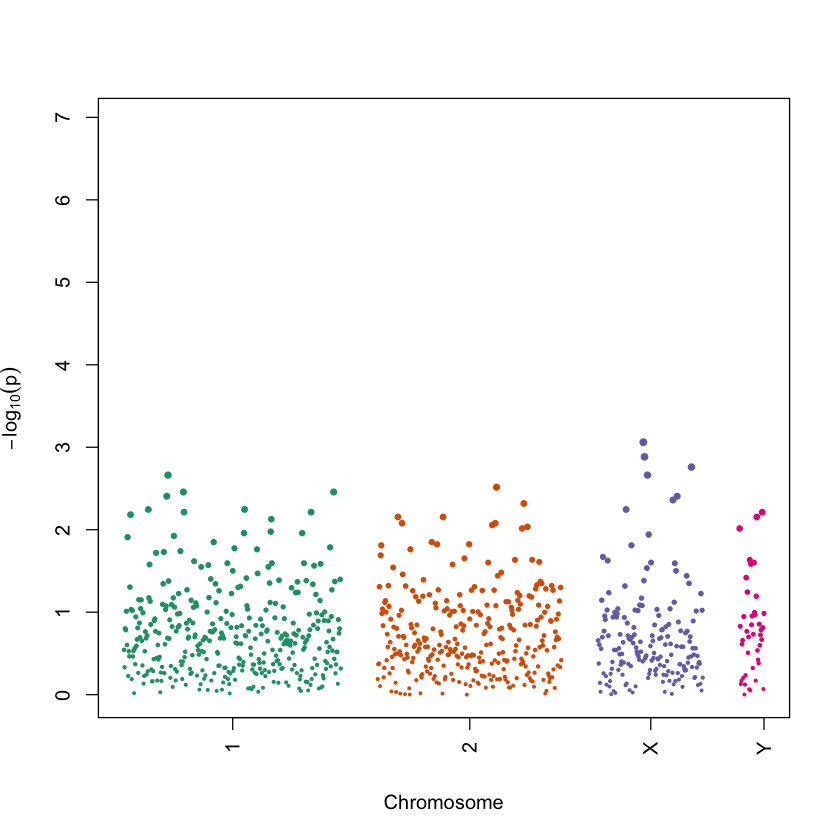

In [109]:
n <- 1000
pvals <- sample(-log10((1:n)/n), n, replace=TRUE)
chromosome <- c(rep(1,400), rep(2,350), rep("X",200), rep("Y",50))
manhattanPlot(pvals, chromosome, signif=1e-7)
manhattanPlot(pvals, chromosome, thinThreshold=2)